# Task 1.3 & 1.5: Feature Extraction and Visualization

This notebook handles:
- **Task 1.3**: Feature hierarchy visualization (t-SNE/UMAP)
- **Task 1.5**: Optional experiments (t-SNE vs UMAP, confusion matrix, ResNet comparison)

**Run training scripts first:**
```bash
python train_resnet.py           # Task 1.1: Baseline
python train_broken.py           # Task 1.2: Broken skip connections
python train_transfer.py --mode random      # Task 1.4b
python train_transfer.py --mode full        # Task 1.4c
python train_transfer.py --mode lastblock   # Task 1.4c
```

In [1]:
import json
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

Using Device: mps


---
## Part 1: Training Results Analysis

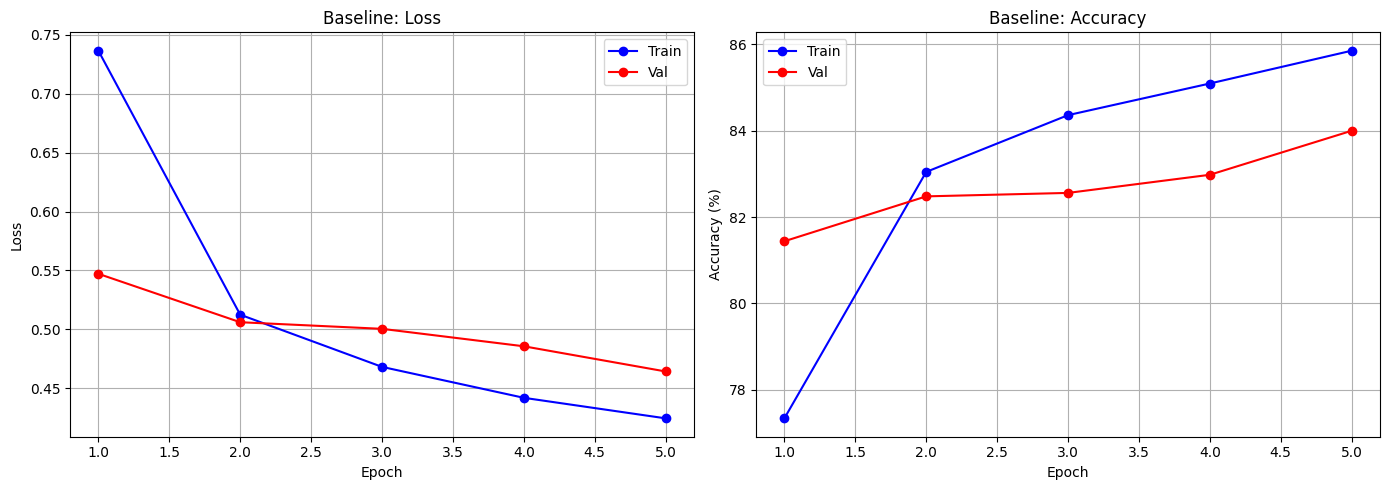

Baseline Final Val Acc: 84.00%


In [2]:
# Load baseline metrics
with open('results/baseline_metrics.json', 'r') as f:
    baseline = json.load(f)

epochs = range(1, len(baseline['train_loss']) + 1)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(epochs, baseline['train_loss'], 'b-o', label='Train')
axes[0].plot(epochs, baseline['val_loss'], 'r-o', label='Val')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].set_title('Baseline: Loss'); axes[0].legend(); axes[0].grid(True)

axes[1].plot(epochs, baseline['train_acc'], 'b-o', label='Train')
axes[1].plot(epochs, baseline['val_acc'], 'r-o', label='Val')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Baseline: Accuracy'); axes[1].legend(); axes[1].grid(True)

plt.tight_layout()
plt.show()
print(f"Baseline Final Val Acc: {baseline['val_acc'][-1]:.2f}%")

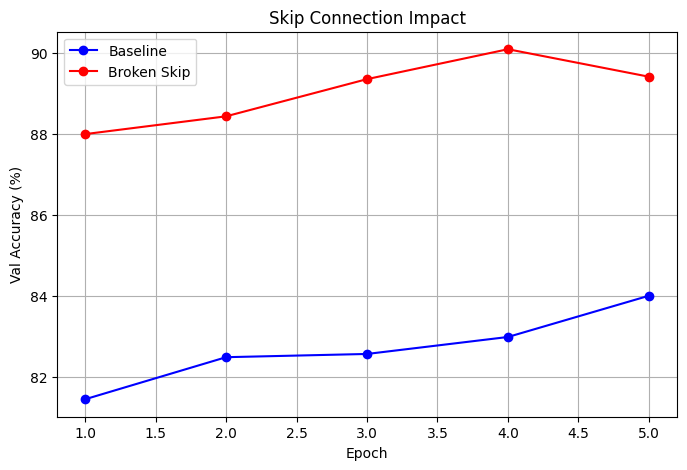

In [3]:
# Compare baseline vs broken skip connections
try:
    with open('results/broken_metrics.json', 'r') as f:
        broken = json.load(f)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(epochs, baseline['val_acc'], 'b-o', label='Baseline')
    ax.plot(range(1, len(broken['val_acc'])+1), broken['val_acc'], 'r-o', label='Broken Skip')
    ax.set_xlabel('Epoch'); ax.set_ylabel('Val Accuracy (%)')
    ax.set_title('Skip Connection Impact'); ax.legend(); ax.grid(True)
    plt.show()
except FileNotFoundError:
    print("Run train_broken.py first")

---
## Part 2: Feature Extraction (Task 1.3)

In [4]:
class FeatureExtractor:
    """Extract features from intermediate layers using forward hooks."""
    def __init__(self, model, layer_names):
        self.features = {}
        self.hooks = []
        for name in layer_names:
            layer = dict(model.named_modules())[name]
            self.hooks.append(layer.register_forward_hook(self._get_hook(name)))
    
    def _get_hook(self, name):
        def hook(module, input, output):
            self.features[name] = output.detach()
        return hook
    
    def extract(self, model, x):
        self.features = {}
        with torch.no_grad():
            _ = model(x)
        return self.features
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

In [5]:
# Load trained model
weights = models.ResNet152_Weights.IMAGENET1K_V2
model = models.resnet152(weights=weights)
model.fc = nn.Linear(2048, 10)
model.load_state_dict(torch.load('checkpoints/resnet_frozen.pth', map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

# Data
preprocess = weights.transforms()
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

print("Model loaded.")

Model loaded.


In [6]:
# Extract features from different layers
layer_names = ['layer1', 'layer2', 'layer3', 'layer4']
extractor = FeatureExtractor(model, layer_names)

all_features = {name: [] for name in layer_names}
all_labels = []
num_samples = 1000
collected = 0

print(f"Extracting features from {num_samples} samples...")
for inputs, labels in tqdm(test_loader):
    if collected >= num_samples:
        break
    inputs = inputs.to(DEVICE)
    features = extractor.extract(model, inputs)
    
    for name in layer_names:
        feat = nn.functional.adaptive_avg_pool2d(features[name], 1).squeeze(-1).squeeze(-1)
        all_features[name].append(feat.cpu().numpy())
    all_labels.extend(labels.numpy())
    collected += len(labels)

extractor.remove_hooks()

# Concatenate
for name in layer_names:
    all_features[name] = np.concatenate(all_features[name])[:num_samples]
all_labels = np.array(all_labels[:num_samples])

print(f"Feature shapes: {[(n, all_features[n].shape) for n in layer_names]}")

Extracting features from 1000 samples...


 10%|█         | 16/157 [00:42<06:11,  2.64s/it]

Feature shapes: [('layer1', (1000, 256)), ('layer2', (1000, 512)), ('layer3', (1000, 1024)), ('layer4', (1000, 2048))]


Computing t-SNE for layer1...
Computing t-SNE for layer2...
Computing t-SNE for layer3...
Computing t-SNE for layer4...


/var/folders/_h/bmfh6c5n1fjgq8yxk8bvjb8w0000gn/T/ipykernel_24257/2619455974.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


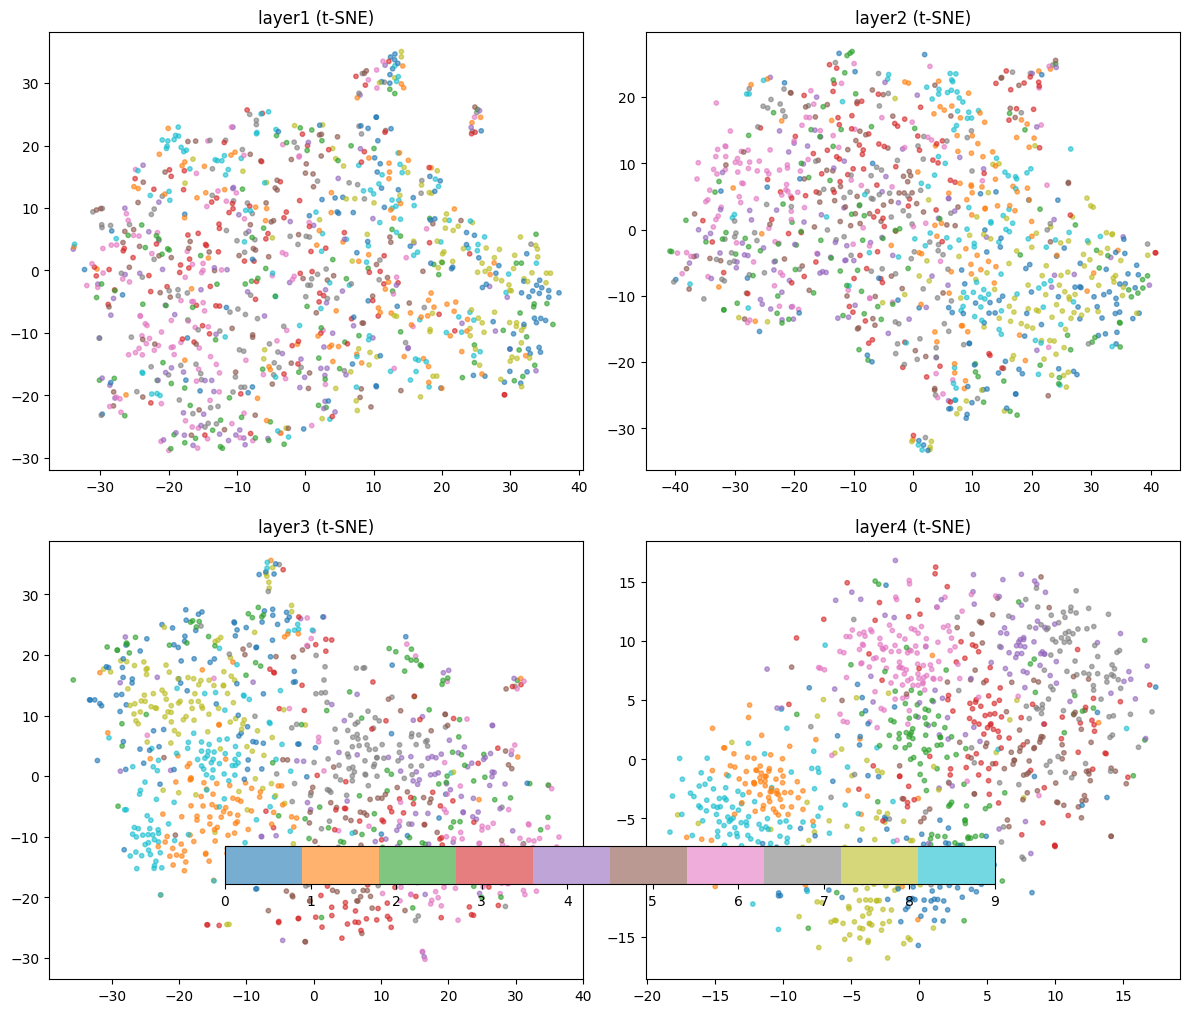

In [7]:
# t-SNE visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, name in enumerate(layer_names):
    print(f"Computing t-SNE for {name}...")
    emb = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(all_features[name])
    sc = axes[idx].scatter(emb[:, 0], emb[:, 1], c=all_labels, cmap='tab10', alpha=0.6, s=10)
    axes[idx].set_title(f'{name} (t-SNE)')

plt.colorbar(sc, ax=axes, orientation='horizontal', fraction=0.05, pad=0.08)
plt.tight_layout()
plt.show()

### Analysis: Class Separability

**Early layers (layer1):** Mixed features, low-level patterns (edges, textures)

**Middle layers (layer2-3):** Emerging class structure, mid-level features

**Late layers (layer4):** Clear class separation, high-level semantic features

Using device: mps
Loaded weights from checkpoints/resnet_frozen.pth
Extracting features from 1000 samples...


 10%|█         | 16/157 [00:39<05:50,  2.49s/it]


Hooks removed.
Feature extraction complete. Shapes: [('layer1', (1000, 256)), ('layer2', (1000, 512)), ('layer3', (1000, 1024)), ('layer4', (1000, 2048))]
Computing t-SNE for layer1...
Computing t-SNE for layer2...
Computing t-SNE for layer3...
Computing t-SNE for layer4...


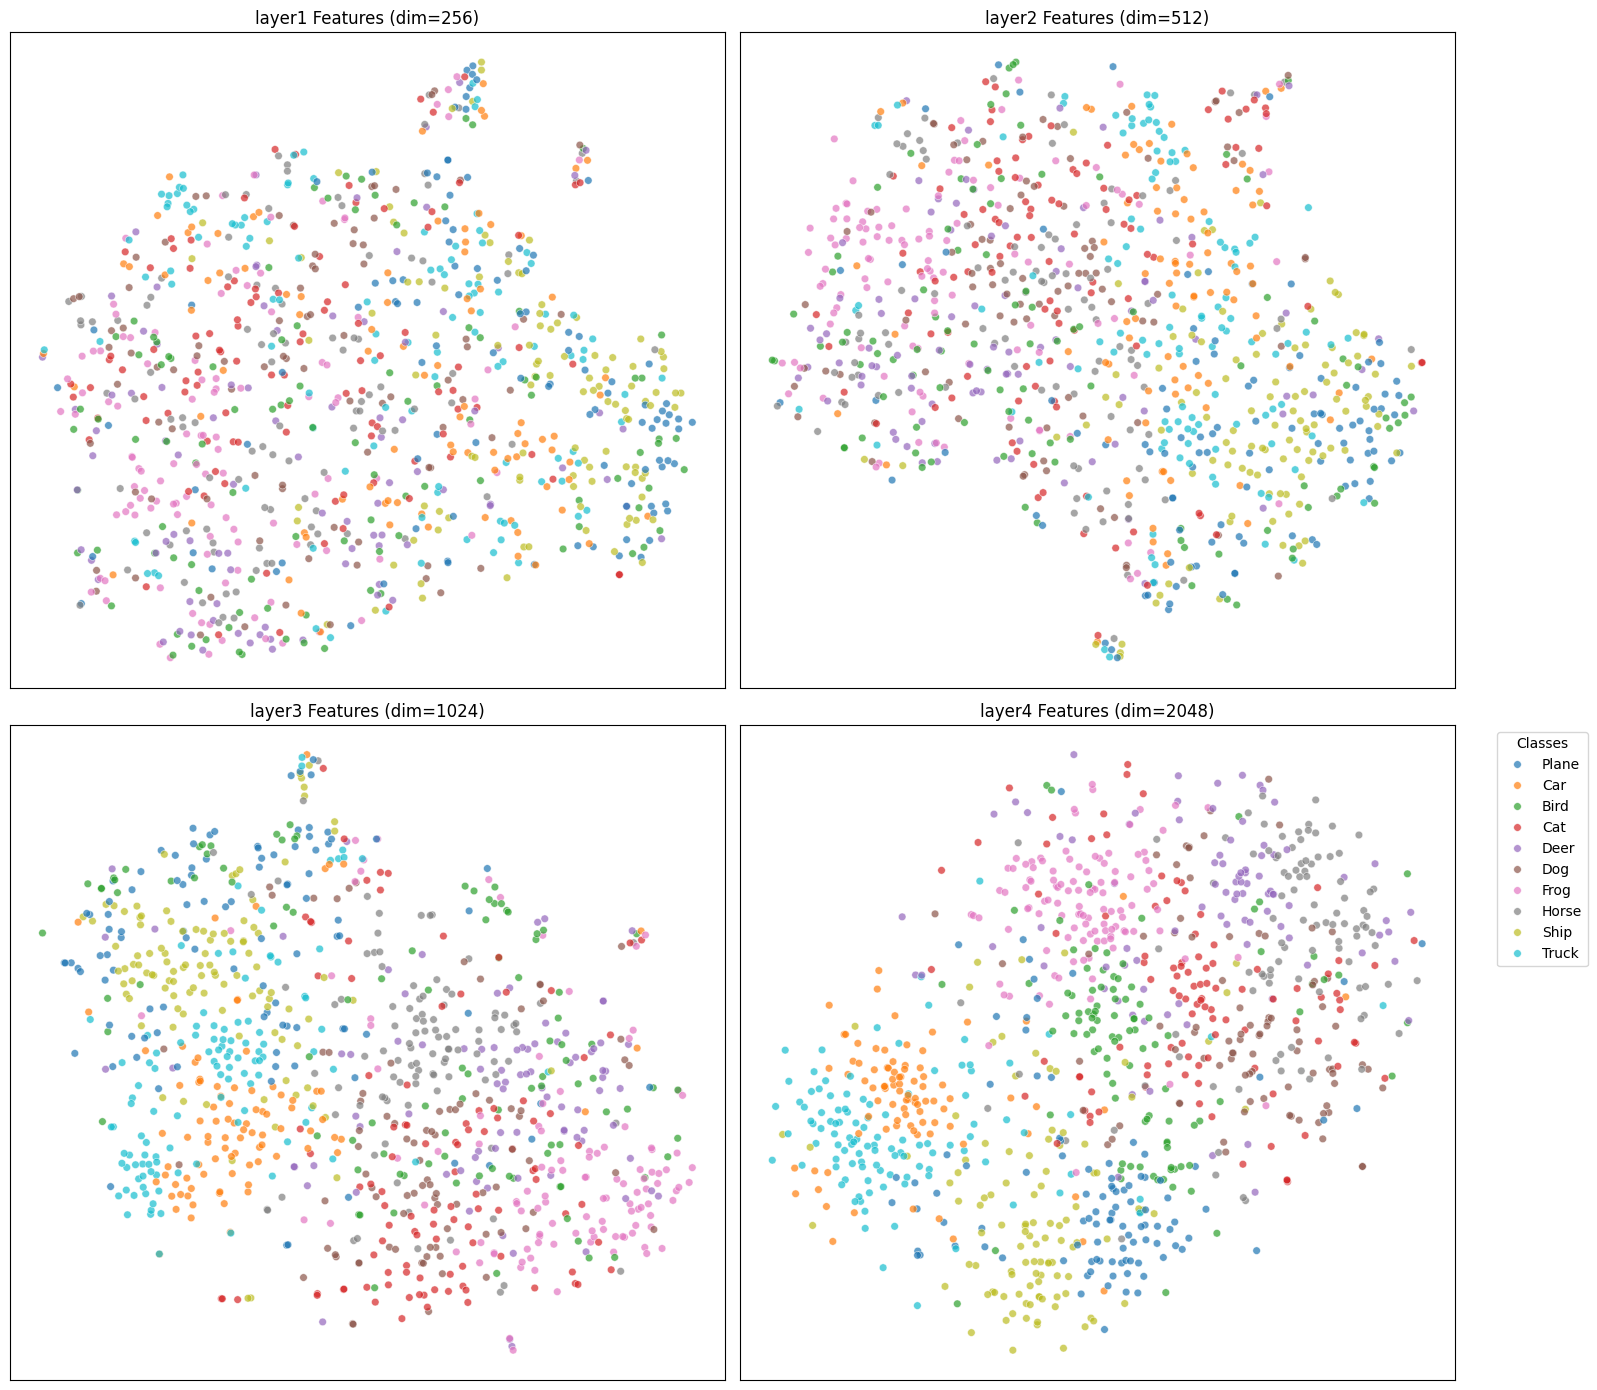

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from torchvision import models, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm

# --- 1. Improved Feature Extractor (Context Manager) ---
class FeatureExtractor:
    """
    Extracts features using forward hooks.
    Acts as a Context Manager to ensure hooks are always removed.
    """
    def __init__(self, model, layer_names):
        self.model = model
        self.layer_names = layer_names
        self.features = {name: None for name in layer_names}
        self.hooks = []

    def _hook_fn(self, name):
        def hook(module, input, output):
            # Global Average Pooling: (B, C, H, W) -> (B, C)
            # This reduces dimensions immediately, saving massive amounts of RAM
            self.features[name] = nn.functional.adaptive_avg_pool2d(output, 1).flatten(1).detach()
        return hook

    def __enter__(self):
        # Register hooks when entering the 'with' block
        for name in self.layer_names:
            layer = dict(self.model.named_modules())[name]
            self.hooks.append(layer.register_forward_hook(self._hook_fn(name)))
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        # Remove hooks when exiting (even if code crashes)
        for hook in self.hooks:
            hook.remove()
        print("Hooks removed.")

# --- 2. Setup & Load Model ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load Model
weights = models.ResNet152_Weights.IMAGENET1K_V2
model = models.resnet152(weights=weights)
model.fc = nn.Linear(2048, 10)

# Load your specific checkpoint
checkpoint_path = 'checkpoints/resnet_frozen.pth'
try:
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"Loaded weights from {checkpoint_path}")
except FileNotFoundError:
    print("Checkpoint not found, using random weights (for testing).")

model = model.to(device)
model.eval()

# Data
preprocess = weights.transforms()
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

# --- 3. Extract Features ---
layer_names = ['layer1', 'layer2', 'layer3', 'layer4']
num_samples = 1000

# Containers
all_features = {name: [] for name in layer_names}
all_labels = []
collected = 0

print(f"Extracting features from {num_samples} samples...")

# Use the 'with' statement for safety
with FeatureExtractor(model, layer_names) as extractor:
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            if collected >= num_samples:
                break
            
            inputs = inputs.to(device)
            _ = model(inputs) # Forward pass triggers hooks
            
            # Collect features from the dictionary populated by hooks
            for name in layer_names:
                all_features[name].append(extractor.features[name].cpu().numpy())
            
            all_labels.extend(labels.numpy())
            collected += len(labels)

# Concatenate results
for name in layer_names:
    all_features[name] = np.concatenate(all_features[name])[:num_samples]
all_labels = np.array(all_labels[:num_samples])

print(f"Feature extraction complete. Shapes: {[(k, v.shape) for k, v in all_features.items()]}")

# --- 4. Visualization (Seaborn + PCA Init + Legends) ---
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
palette = sns.color_palette("tab10", 10)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, name in enumerate(layer_names):
    print(f"Computing t-SNE for {name}...")
    
    # Improvement: Use init='pca' for better stability and structure preservation
    # learning_rate='auto' is the modern default for sklearn
    tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto', random_state=42)
    emb = tsne.fit_transform(all_features[name])
    
    # Use Seaborn for cleaner plotting with automated legends
    sns.scatterplot(
        x=emb[:, 0], y=emb[:, 1],
        hue=all_labels, 
        palette=palette,
        legend='full' if idx == 3 else False, # Only show legend on last plot to save space
        ax=axes[idx],
        s=30, alpha=0.7
    )
    
    axes[idx].set_title(f'{name} Features (dim={all_features[name].shape[1]})')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

# Fix Legend: Replace numbers with Class Names
if axes[3].get_legend():
    handles, _ = axes[3].get_legend_handles_labels()
    # Position legend outside the plot
    axes[3].legend(handles, classes, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

---
## Part 3: Transfer Learning Comparison (Task 1.4)

In [ ]:
# Load transfer learning results
transfer_results = {}
for mode in ['random', 'full', 'lastblock']:
    try:
        with open(f'results/{mode}_metrics.json', 'r') as f:
            transfer_results[mode] = json.load(f)
    except FileNotFoundError:
        print(f"Missing: results/{mode}_metrics.json - run train_transfer.py --mode {mode}")

if transfer_results:
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = {'random': 'r', 'full': 'b', 'lastblock': 'g'}
    
    for mode, hist in transfer_results.items():
        ax.plot(range(1, len(hist['val_acc'])+1), hist['val_acc'], 
                f'{colors[mode]}-o', label=mode)
    
    ax.set_xlabel('Epoch'); ax.set_ylabel('Val Accuracy (%)')
    ax.set_title('CIFAR-100 Transfer Learning Comparison')
    ax.legend(); ax.grid(True)
    plt.show()
    
    print("\nFinal Accuracies:")
    for mode, hist in transfer_results.items():
        print(f"  {mode}: {hist['val_acc'][-1]:.2f}%")

---
## Part 4: Optional Experiments (Task 1.5)

In [ ]:
# t-SNE vs UMAP comparison
try:
    import umap
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    print("Computing t-SNE...")
    tsne_emb = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(all_features['layer4'])
    
    print("Computing UMAP...")
    umap_emb = umap.UMAP(n_components=2, random_state=42).fit_transform(all_features['layer4'])
    
    axes[0].scatter(tsne_emb[:, 0], tsne_emb[:, 1], c=all_labels, cmap='tab10', alpha=0.6, s=10)
    axes[0].set_title('layer4 - t-SNE')
    
    axes[1].scatter(umap_emb[:, 0], umap_emb[:, 1], c=all_labels, cmap='tab10', alpha=0.6, s=10)
    axes[1].set_title('layer4 - UMAP')
    
    plt.tight_layout()
    plt.show()
except ImportError:
    print("UMAP not installed. Run: pip install umap-learn")

In [ ]:
# Confusion Matrix
all_preds, all_true = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE))
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.numpy())

cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CIFAR10_CLASSES, yticklabels=CIFAR10_CLASSES)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix - ResNet-152 on CIFAR-10')
plt.tight_layout()
plt.show()

# Most confused pairs
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
print("\nMost Confused Pairs:")
for _ in range(5):
    i, j = np.unravel_index(cm_copy.argmax(), cm_copy.shape)
    print(f"  {CIFAR10_CLASSES[i]} → {CIFAR10_CLASSES[j]}: {cm_copy[i,j]} errors")
    cm_copy[i, j] = 0

In [ ]:
# ResNet-18 vs ResNet-152 comparison
from utils import train_one_epoch, evaluate
import torch.optim as optim
from torch.utils.data import random_split

# Prepare data loaders for training
full_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess)
train_data, val_data = random_split(full_train, [45000, 5000], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=2)

# Train ResNet-18
print("Training ResNet-18 baseline...")
r18_weights = models.ResNet18_Weights.IMAGENET1K_V1
model_r18 = models.resnet18(weights=r18_weights)
for p in model_r18.parameters():
    p.requires_grad = False
model_r18.fc = nn.Linear(512, 10)
model_r18 = model_r18.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_r18.fc.parameters(), lr=0.001)

history_r18 = {'val_acc': []}
for epoch in range(5):
    train_one_epoch(model_r18, train_loader, criterion, optimizer, DEVICE)
    _, val_acc = evaluate(model_r18, val_loader, criterion, DEVICE)
    history_r18['val_acc'].append(val_acc)

print(f"\nResNet-152 Final Val Acc: {baseline['val_acc'][-1]:.2f}%")
print(f"ResNet-18 Final Val Acc: {history_r18['val_acc'][-1]:.2f}%")

---
## Summary

1. **Baseline**: Frozen backbone achieves ~84% on CIFAR-10
2. **Skip connections**: Essential for gradient flow
3. **Feature hierarchies**: Increasing class separability in deeper layers
4. **Transfer learning**: Pretrained weights >> random; last block fine-tuning is optimal trade-off
5. **Optional**: Confusion analysis, t-SNE vs UMAP, ResNet depth comparison